In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [24]:
x_dic = {}
for i in range(1, 101):
    if i % 10 ==0:
        print(i)
    df = pd.read_excel('41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name = i, skiprows = 1)
    xi = df['Mid-Atlantic Region'].tolist()
    x_dic['x'+str(i)] = xi

In [35]:
df = pd.read_excel('41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name=1, header = 1)

# Combine 45 queries
dict = {'date': df['Date'].tolist()}
for i in range(1, 46):
    if i % 5 ==0:
        print(i)
    df = pd.read_excel('41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name=i, header = 1)
    dict['query'+str(i)] = df['Mid-Atlantic Region'].tolist()
dat = pd.DataFrame.from_dict(dict)
dat.head()

5
10
15
20
25
30
35
40
45


,date,query1,query2,query3,query4,query5,query6,query7,query8,query9,...,query36,query37,query38,query39,query40,query41,query42,query43,query44,query45
0,2003-06-01,0.990,6.471,6.899,0.990,1.448,1.581,0.118,0.517,0.813,...,0.414,0.103,0.606,0.163,0.355,0.827,0.163,0.295,2.822,2.245
1,2003-06-08,0.806,6.063,6.992,0.964,1.227,1.647,0.123,0.280,0.596,...,0.543,0.158,0.561,0.210,0.210,1.577,0.228,0.193,2.664,2.050
2,2003-06-15,0.892,5.044,6.130,0.912,0.912,1.765,0.019,0.485,0.640,...,0.582,0.194,0.737,0.175,0.310,1.377,0.136,0.330,3.240,2.541
3,2003-06-22,1.149,5.033,5.054,0.710,0.668,2.068,0.104,0.230,0.564,...,0.272,0.125,0.522,0.167,0.313,1.587,0.230,0.292,2.318,2.088
4,2003-06-29,0.768,4.920,5.128,0.685,0.727,1.868,0.021,0.270,0.374,...,0.415,0.104,0.374,0.083,0.145,1.100,0.187,0.353,2.553,2.284


In [58]:

dat['date'] = pd.to_datetime(dat['date'])

In [56]:
df0 = pd.read_csv('FluView_LineChart_Data-0.csv', skiprows = 1)
df1 = pd.read_csv('FluView_LineChart_Data-1.csv', skiprows = 1)
df2 = pd.read_csv('FluView_LineChart_Data-2.csv', skiprows = 1)
df3 = pd.read_csv('FluView_LineChart_Data-3.csv', skiprows = 1)
df4 = pd.read_csv('FluView_LineChart_Data-4.csv', skiprows = 1)
df5 = pd.read_csv('FluView_LineChart_Data-5.csv', skiprows = 1)
df6 = pd.read_csv('FluView_LineChart_Data-6.csv', skiprows = 1)

y = pd.concat([df0, df1, df2, df3, df4, df5, df6])
y = y[y['YEAR'] > 2002]
y = y[((y['YEAR']==2003)&(y['WEEK'] > 22)) | (y['YEAR'] > 2003) ][:dat['date'].size]

y = y['% WEIGHTED ILI']

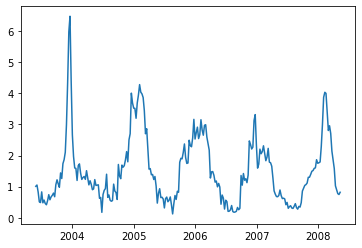

In [61]:
plt.plot(dat['date'], y);


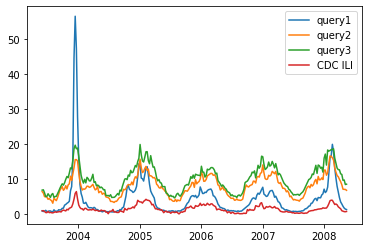

In [62]:
plt.plot(dat['date'], dat['query1'], label = 'query1')
plt.plot(dat['date'], dat['query2'], label = 'query2')
plt.plot(dat['date'], dat['query3'], label = 'query3')
plt.plot(dat['date'], y,  label = 'CDC ILI')
plt.legend()
plt.show()

In [64]:
dat['y'] = y.tolist()

In [66]:
for i in range(1, 8):
    dat["lag_{}".format(i)] = dat['y'].shift(i)
print("done")
dat=dat.fillna(0)

done


In [68]:
y = dat['y']
date = dat['date']
X = dat.drop(['y', 'date'], axis = 1)

In [70]:
N = 50
X_train = X.iloc[:N,]
X_test = X.iloc[N:,]
y_train = y[:N]
y_test = y[N:]

# 利用弹性网络
from sklearn.model_selection import cross_val_score
cv_model = ElasticNetCV(l1_ratio=0.5, eps=1e-3, n_alphas=200, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=200, tol=0.006, cv=10, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

# 训练模型              
cv_model.fit(X_train, y_train)

# 计算最佳迭代次数、alpha和ratio
print('最佳 alpha: %.8f'%cv_model.alpha_)
print('最佳 l1_ratio: %.3f'%cv_model.l1_ratio_)
print('迭代次数 %d'%cv_model.n_iter_)

最佳 alpha: 0.00182915
最佳 l1_ratio: 0.500
迭代次数 194


In [71]:
# 输出结果
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.9873244857086348
Test r2 score:  0.8287650579933128
Train RMSE: 0.1404
Test RMSE: 0.4257


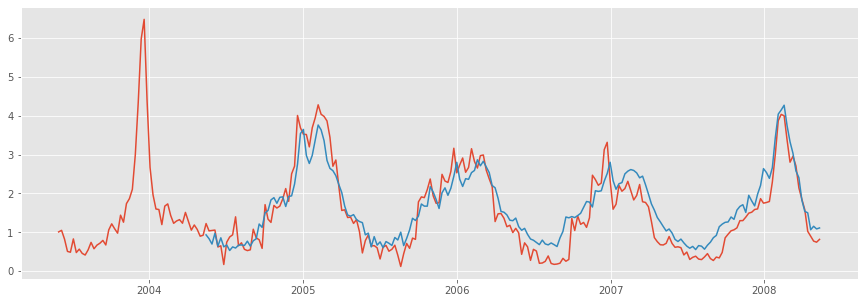

In [72]:
import datetime
plt.style.use('ggplot')

plt.rcParams.update({'figure.figsize': (15, 5)})

plt.plot(date, y)
plt.plot(date[N:], y_pred)

plt.show()